### Kittinun Yenyueak, FAN ID: yeny0002, SRN: 2283846

## Library

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch_lr_finder import LRFinder

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

In [2]:
# load ModelBuilder into the worksheet
%run -i /content/handy_code/ModelBuilder.py

In [3]:
# use command to run model faster
# torch.set_float32_matmul_precision('medium')
# torch.float16

## Data preparation

In [4]:
# define the transformation to convert to tensor
transform = transforms.ToTensor()

# load dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# split the dataset
torch.manual_seed(42)
train_set, val_set, test_set, not_use = random_split(train_dataset, [15000, 5000, 5000, 25000])

In [6]:
# define original classes
classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 7:'horse', 8:'ship', 9:'truck'}

In [7]:
train_set[0][0].shape

torch.Size([3, 32, 32])

In [8]:
# create function to display image new_classes
def image(img, label):
    np_img = img.numpy()
    # normalise the image values to [0, 1] for display
    np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(np_img, (1,2,0))) # transpose to rgb
    plt.xlabel(classes[label])
    plt.show

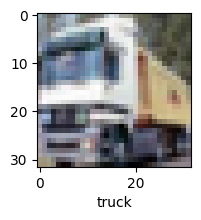

In [9]:
img, label = train_dataset[1]  # train_set[0] contains (image, label)
image(img, label)

In [10]:
# new class regarding on 46%3 = 1; version 1
    # 0: 'airplane/automobile',
    # 1: 'frog/truck',
    # 2: 'bird/cat/deer/dog',
    # 3: 'horse',
    # 4: 'ship/automobile
new_classes = {0: 0, 1: 4, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 3, 8: 4, 9: 1}

In [11]:
# modify the labels in place
new_mapped_labels = [new_classes[label] for _, label in train_dataset]
for idx, (_, label) in enumerate(train_dataset):
    train_dataset.targets[idx] = new_mapped_labels[idx]

In [27]:
# create function to display image new_classes
def image(img, label):
    np_img = img.numpy()
    # normalise the image values to [0, 1] for display
    np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(np_img, (1,2,0))) # transpose to rgb
    plt.xlabel(new_classes[label])
    plt.show

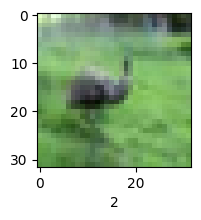

In [13]:
img, label = train_set[1]  # train_set[0] contains (image, label)
image(img, label)

## Model design and training

In [14]:
# create loader
torch.manual_seed(42)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Setting batch size = 64 means to have 64 samples per batch to load. The batch size widely selected from 8 to 128 samples hence the larger number make poorer generalisation. (ref: https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU)

In [15]:
# recheck data size
print("Number of samples in train dataset:", len(train_loader.dataset))
print("Number of samples in test dataset:", len(test_loader.dataset))
print("Number of samples in val dataset:", len(val_loader.dataset))

Number of samples in train dataset: 15000
Number of samples in test dataset: 5000
Number of samples in val dataset: 5000


In [16]:
# model configuration
# apply convolutional nn 2 blocks
torch.manual_seed(42)
m2 = nn.Sequential()
# featuriser
# block 1
m2.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
m2.add_module('relu1', nn.ReLU()) # activation
m2.add_module('maxp1', nn.MaxPool2d(kernel_size=2, stride =2)) # pooling

# block 2
m2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
m2.add_module('relu2', nn.ReLU())
m2.add_module('maxp2', nn.MaxPool2d(kernel_size=2, stride =2))

# Flattening
m2.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
m2.add_module('fc1', nn.Linear(in_features=8*8*64, out_features=64))
m2.add_module('relu3', nn.ReLU())
# m2.add_module('dropout', nn.Dropout(p=0.5))
# Output Layer
m2.add_module('fc2', nn.Linear(in_features=64, out_features=5)) # number of new clasess

In [17]:
# train model
torch.manual_seed(42)
lr = 0.02
multi_loss_fn = nn.CrossEntropyLoss()
optimizer_m2 = optim.SGD(m2.parameters(), lr=lr)

n_epochs = 200
cnn_m2 = ModelBuilder(m2, multi_loss_fn, optimizer_m2, print_loss_freq=5)
cnn_m2.set_loaders(train_loader, val_loader)
cnn_m2.train(n_epochs, target_accuracy=0.75) # modidfied function to have stop when accuaracy = 0.75

Epoch 5, Train Loss: 1.1297, Train Acc: 0.5587, Val Loss: 1.0954, Val Acc: 0.5642
Epoch 10, Train Loss: 0.9364, Train Acc: 0.6288, Val Loss: 0.9634, Val Acc: 0.6142
Epoch 15, Train Loss: 0.8066, Train Acc: 0.6741, Val Loss: 0.8798, Val Acc: 0.6472
Epoch 20, Train Loss: 0.7059, Train Acc: 0.7049, Val Loss: 0.8493, Val Acc: 0.6686
Epoch 25, Train Loss: 0.6105, Train Acc: 0.7613, Val Loss: 0.7556, Val Acc: 0.7096
Epoch 30, Train Loss: 0.5343, Train Acc: 0.8010, Val Loss: 0.7088, Val Acc: 0.7310
Epoch 35, Train Loss: 0.4558, Train Acc: 0.8125, Val Loss: 0.7781, Val Acc: 0.7196
Epoch 40, Train Loss: 0.3731, Train Acc: 0.8353, Val Loss: 0.8171, Val Acc: 0.7108
Epoch 45, Train Loss: 0.3023, Train Acc: 0.8579, Val Loss: 0.8403, Val Acc: 0.7036
Epoch 50, Train Loss: 0.2247, Train Acc: 0.9471, Val Loss: 0.7906, Val Acc: 0.7446
Early stopping at epoch 53 as validation accuracy reached 75.40%


Training the model with learning rate = 0.02 and number of epoch = 200, the model was trained for 53 epoches to acheive validation 75% accuracy. The traninig model method was modified to stop learning as soon as it reach 75% to prevent models take long time and more overfit.

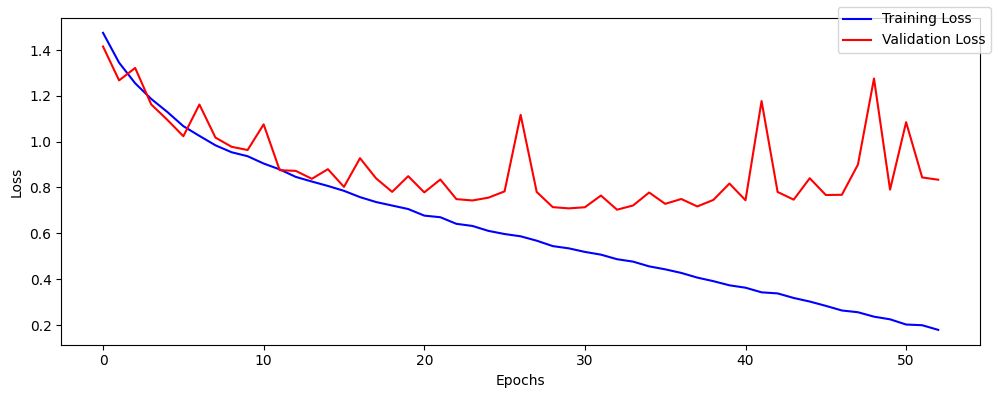

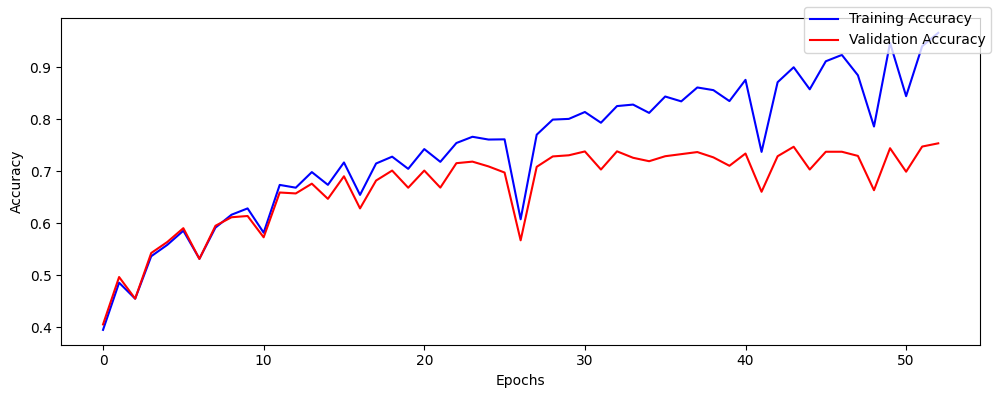

In [18]:
cnn_m2.plot_losses()
cnn_m2.plot_accuracies()

The pattern of Losses shows the model fits the trainning data well but doesnot generalise to validation set as show it start to overfit around epochs 20.

The gap between on training and validation accuracy suggests the model performs better on the training data compared to the validation data.

In [19]:
# calculate validation set accuracy
val_acc = cnn_m2.calculate_accuracy(val_loader)
print(f"Validation Accuracy for m2: {val_acc*100:.2f}%")

Validation Accuracy for m2: 75.40%


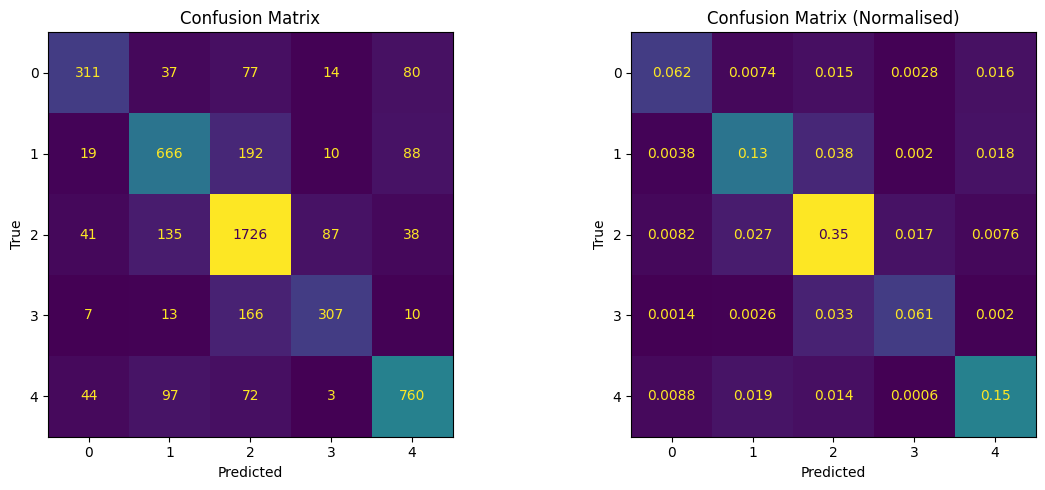

In [20]:
# plot confusion maxtrix  on validation loader
val_preds, val_labels = cnn_m2.generate_confusion_matrix(val_loader)
cnn_m2.plot_confusion_matrix(val_labels, val_preds)

The model performs best for "Class 2" but struggles with other classes, especially Class 0 and Class 1. As shown the number of misclassified elements are quite high.

## Model Evaluation

Using test set data provides an unbiased estimate of the model performance on unseen data, acting as a final check on the model generalisability

In [21]:
# calculate accuracy on test loader
test_acc = cnn_m2.calculate_accuracy(test_loader)
print(f"Test Accuracy for m2 model: {test_acc * 100:.2f}%")

Test Accuracy for m2 model: 75.18%


Then find accuracy for the test loader which acheive 75.18%

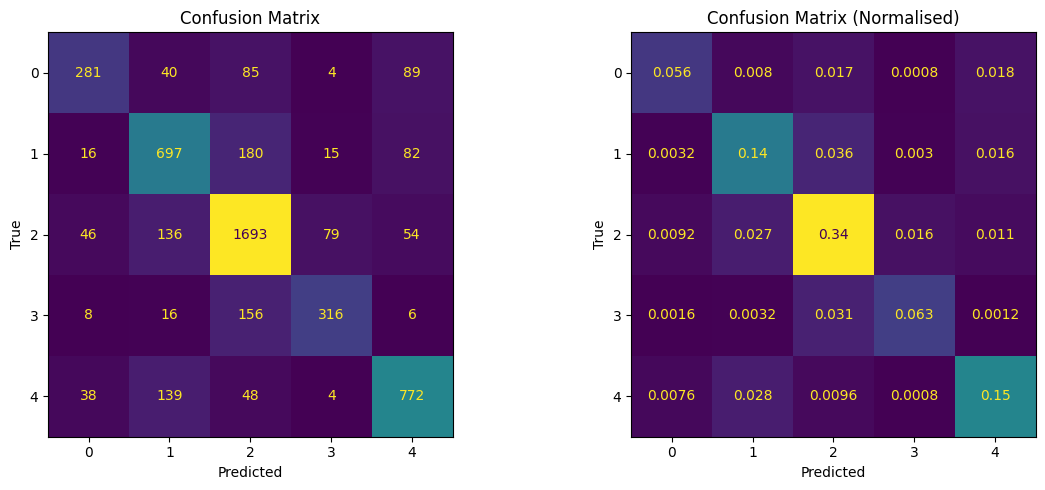

In [22]:
# plot confusion maxtrix  on test loader
test_preds, test_labels = cnn_m2.generate_confusion_matrix(test_loader)
cnn_m2.plot_confusion_matrix(test_labels, test_preds)

The test loader confusion matrix showns quite similar to the validation that The model performs well for Class 2 but Class 0 and 1 are not. The model performs reliably for Class 2, indicating robustness for this class, potentially due to higher representation in the dataset.

## Deeper Model

In [41]:
# apply convolutional nn 3 blocks
torch.manual_seed(42)
m3 = nn.Sequential()
# featuriser
# block 1
m3.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
m3.add_module('relu1', nn.ReLU()) # activation
m3.add_module('maxp1', nn.MaxPool2d(kernel_size=2, stride =2)) # pooling

# block 2
m3.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
m3.add_module('relu2', nn.ReLU())
m3.add_module('maxp2', nn.MaxPool2d(kernel_size=2, stride =2))

# block 3
m3.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
m3.add_module('relu3', nn.ReLU())
m3.add_module('maxp3', nn.MaxPool2d(kernel_size=2, stride =2))

# Flattening
m3.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
m3.add_module('fc1', nn.Linear(in_features=4*4*128, out_features=64))
m3.add_module('relu4', nn.ReLU())
# m3.add_module('dropout', nn.Dropout(p=0.5))
# Output Layer
m3.add_module('fc2', nn.Linear(in_features=64, out_features=5)) # number of new clasess

In [42]:
# train model m3
torch.manual_seed(42)
lr = 0.02
multi_loss_fn_m3 = nn.CrossEntropyLoss()
optimizer_m3 = optim.SGD(m3.parameters(), lr=lr)

n_epochs = 100
cnn_m3 = ModelBuilder(m3, multi_loss_fn_m3, optimizer_m3,print_loss_freq=5)
cnn_m3.set_loaders(train_loader, val_loader)
cnn_m3.train(n_epochs, target_accuracy=0.75)

Epoch 5, Train Loss: 1.2722, Train Acc: 0.5067, Val Loss: 1.2307, Val Acc: 0.5128
Epoch 10, Train Loss: 1.0493, Train Acc: 0.5661, Val Loss: 1.0986, Val Acc: 0.5656
Epoch 15, Train Loss: 0.9326, Train Acc: 0.6413, Val Loss: 0.9317, Val Acc: 0.6368
Epoch 20, Train Loss: 0.8277, Train Acc: 0.6757, Val Loss: 0.8722, Val Acc: 0.6544
Epoch 25, Train Loss: 0.7149, Train Acc: 0.7283, Val Loss: 0.7786, Val Acc: 0.7062
Epoch 30, Train Loss: 0.6147, Train Acc: 0.7781, Val Loss: 0.7039, Val Acc: 0.7338
Epoch 35, Train Loss: 0.5270, Train Acc: 0.7752, Val Loss: 0.7882, Val Acc: 0.7160
Epoch 40, Train Loss: 0.4348, Train Acc: 0.8144, Val Loss: 0.7548, Val Acc: 0.7274
Early stopping at epoch 41 as validation accuracy reached 75.46%


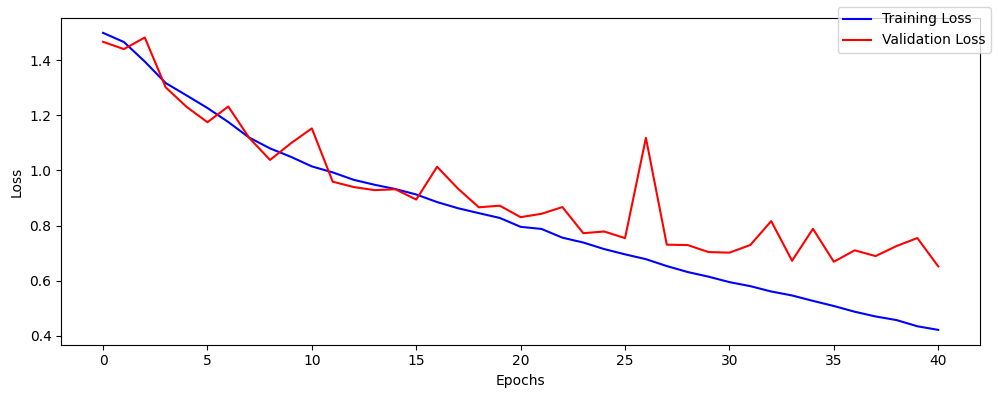

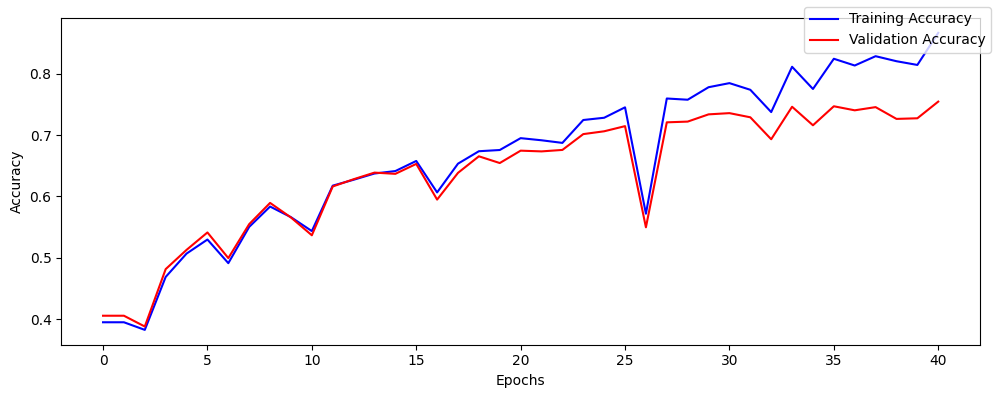

In [43]:
cnn_m3.plot_losses()
cnn_m3.plot_accuracies()

adding more cnn block has lower n_epoch to acheive 75% accuracy comparing with the same learning rate = 0.02 Moreover, the plots are showing lower overfitting sign more than m2 model.

In [44]:
# calculate validation set accuracy
val_acc = cnn_m3.calculate_accuracy(val_loader)
print(f"Validation Accuracy for m3: {val_acc*100:.2f}%")

Validation Accuracy for m3: 75.46%


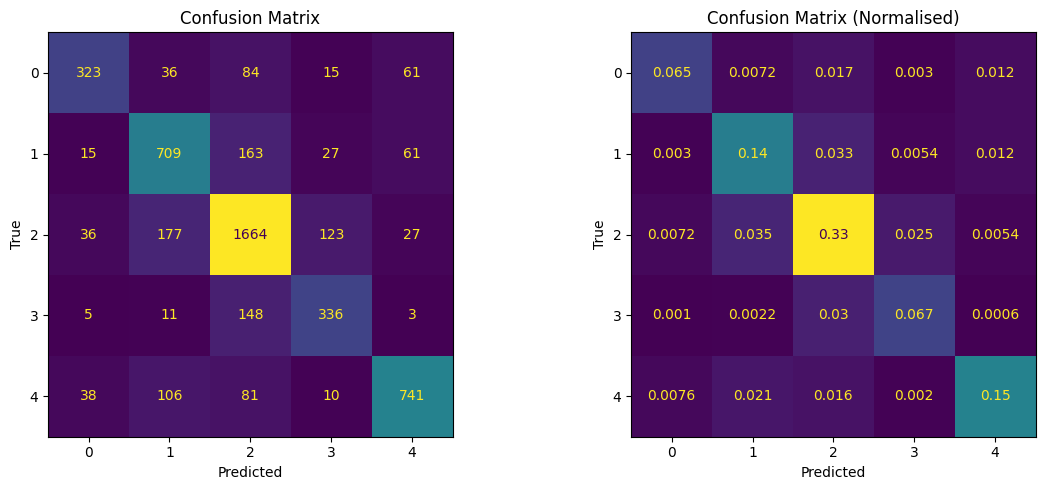

In [57]:
# plot confusion maxtrix  on val loader
val_m3_preds, val_m3_labels = cnn_m3.generate_confusion_matrix(val_loader)
cnn_m3.plot_confusion_matrix(val_m3_labels, val_m3_preds)

The model performs well on Class 2 but struggles with Class 1 and Class 3 where misclassifications are more frequent.

In [50]:
# calculate test set accuracy
test_acc = cnn_m3.calculate_accuracy(test_loader)
print(f"Test Accuracy for m3 model: {test_acc*100:.2f}%")

Test Accuracy for m3 model: 75.54%


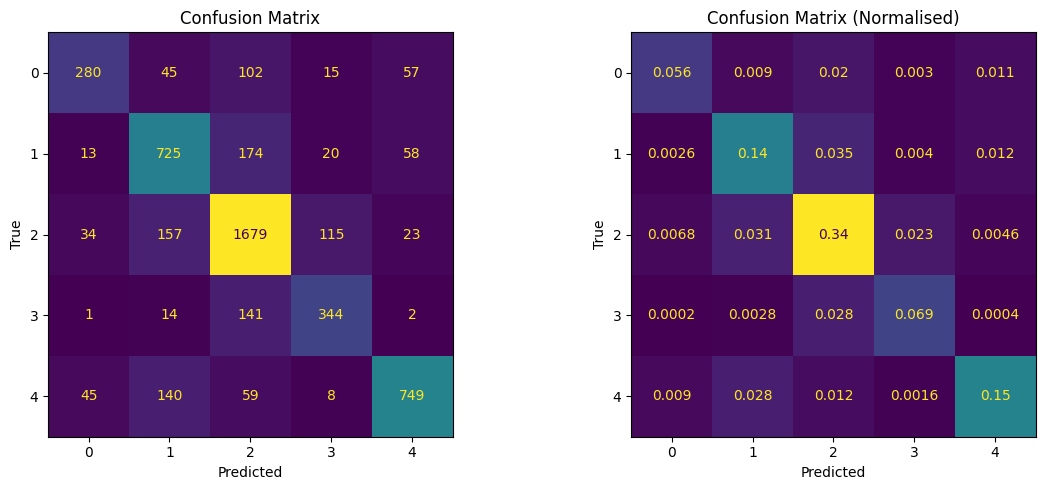

In [56]:
# plot confusion maxtrix  on test loader
test_m3_preds, test_m3_labels = cnn_m3.generate_confusion_matrix(test_loader)
cnn_m3.plot_confusion_matrix(test_m3_labels, test_m3_preds)

The test set results are consistent with the validation set, which suggests that the model has not overfitted to the validation data.

**m2 model and m3 model**

Test accuracy for m3 model has slightly higher than m2 model (75.54% for m3 and 75.18% for m2). The models were used the same learning rate at 0.02. Model m3 can achieve validation 75% accuracy at epoches = 41 while m2 can do at 53, this shows the improvement in model training. Losses and accuracy plot also show that m3 model shown fewer fluctuations in validation loss and accuracy, suggesting it is slightly more stable. However, both models display some overfitting.


## Model improvement

m2 model will be chosen to be improve by using these interventions


### 1) Normalise data

In [64]:
# normalisation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # using normalise feature

# apply the transformation to datasets
train_set.transform = transform
val_set.transform = transform
test_set.transform = transform

# create loader
train_loader_norm = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader_norm = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader_norm = DataLoader(test_set, batch_size=64, shuffle=False)

In [65]:
# model configuration
# apply convolutional nn 2 blocks
torch.manual_seed(42)
m2 = nn.Sequential()
# featuriser
# block 1
m2.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
m2.add_module('relu1', nn.ReLU()) # activation
m2.add_module('maxp1', nn.MaxPool2d(kernel_size=2, stride =2)) # pooling

# block 2
m2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
m2.add_module('relu2', nn.ReLU())
m2.add_module('maxp2', nn.MaxPool2d(kernel_size=2, stride =2))

# Flattening
m2.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
m2.add_module('fc1', nn.Linear(in_features=8*8*64, out_features=64))
m2.add_module('relu3', nn.ReLU())
# m2.add_module('dropout', nn.Dropout(p=0.5))
# Output Layer
m2.add_module('fc2', nn.Linear(in_features=64, out_features=5)) # number of new clasess

In [66]:
torch.manual_seed(42)

lr = 0.02
multi_loss_fn_m2_norm = nn.CrossEntropyLoss()
optimizer_m2_norm = optim.SGD(m2.parameters(), lr=lr)

n_epochs = 100
cnn_norm_m2 = ModelBuilder(m2, multi_loss_fn_m2_norm, optimizer_m2_norm, print_loss_freq=5)
cnn_norm_m2.set_loaders(train_loader_norm, val_loader_norm)
cnn_norm_m2.train(n_epochs, target_accuracy=0.75)

Epoch 5, Train Loss: 1.1297, Train Acc: 0.5587, Val Loss: 1.0954, Val Acc: 0.5642
Epoch 10, Train Loss: 0.9364, Train Acc: 0.6288, Val Loss: 0.9634, Val Acc: 0.6142
Epoch 15, Train Loss: 0.8066, Train Acc: 0.6741, Val Loss: 0.8798, Val Acc: 0.6472
Epoch 20, Train Loss: 0.7059, Train Acc: 0.7049, Val Loss: 0.8493, Val Acc: 0.6686
Epoch 25, Train Loss: 0.6105, Train Acc: 0.7613, Val Loss: 0.7556, Val Acc: 0.7096
Epoch 30, Train Loss: 0.5343, Train Acc: 0.8010, Val Loss: 0.7088, Val Acc: 0.7310
Epoch 35, Train Loss: 0.4558, Train Acc: 0.8125, Val Loss: 0.7781, Val Acc: 0.7196
Epoch 40, Train Loss: 0.3731, Train Acc: 0.8353, Val Loss: 0.8171, Val Acc: 0.7108
Epoch 45, Train Loss: 0.3023, Train Acc: 0.8579, Val Loss: 0.8403, Val Acc: 0.7036
Epoch 50, Train Loss: 0.2247, Train Acc: 0.9471, Val Loss: 0.7906, Val Acc: 0.7446
Early stopping at epoch 53 as validation accuracy reached 75.40%


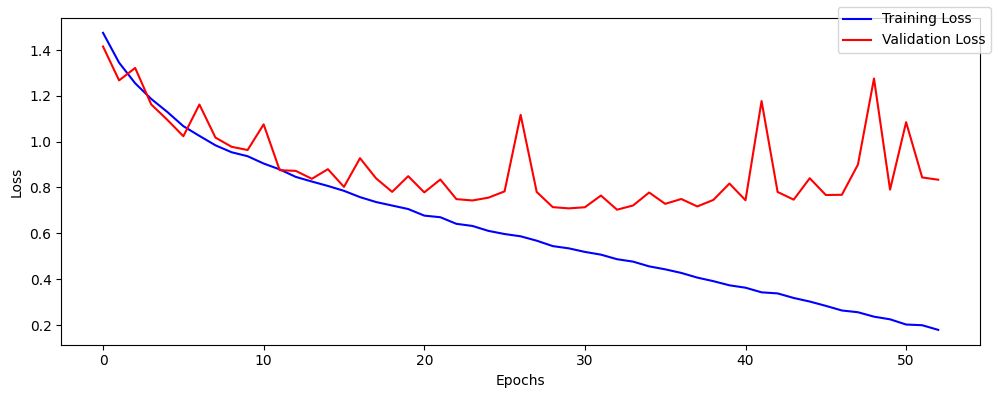

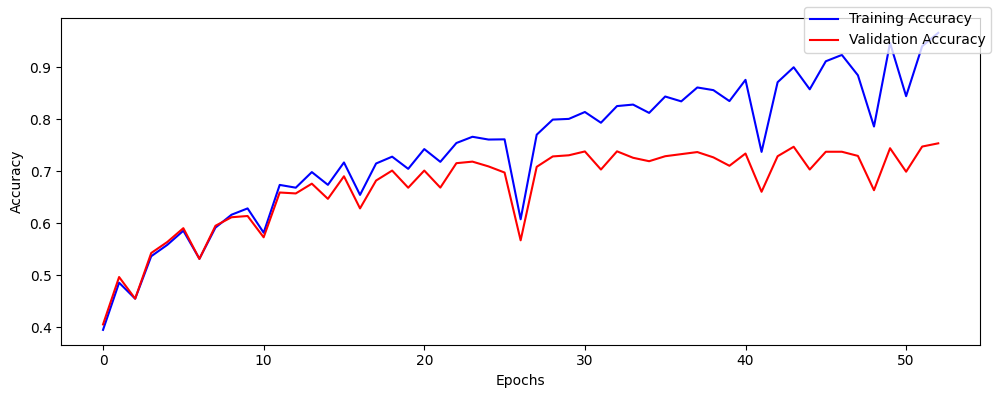

In [67]:
cnn_norm_m2.plot_losses()
cnn_norm_m2.plot_accuracies()

In [68]:
# evaluate on test_loader
test_acc = cnn_norm_m2.calculate_accuracy(test_loader_norm)
print(f"Test Accuracy for m2: {test_acc*100:.2f}%")

Test Accuracy for m2: 75.18%


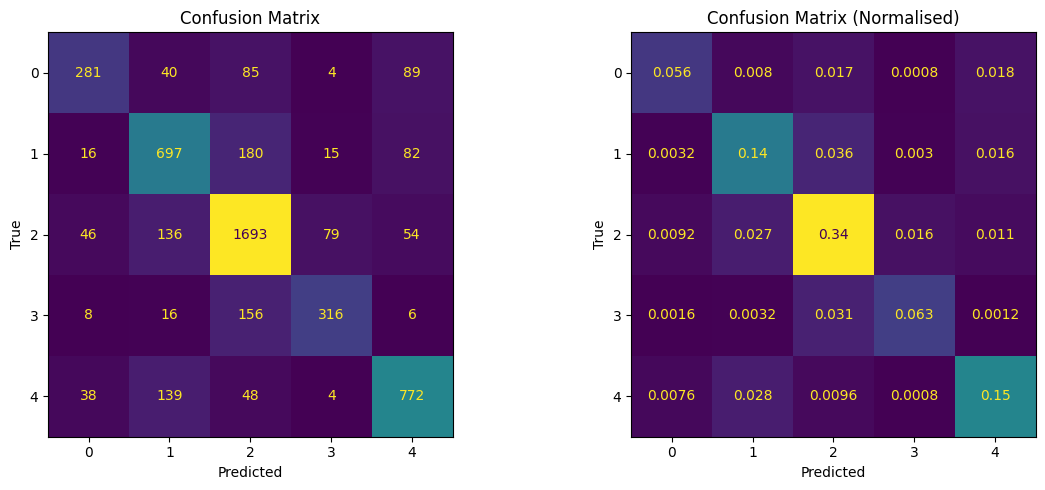

In [91]:
# plot confusion maxtrix  on test loader
test_norm_preds, test_norm_labels = cnn_norm_m2.generate_confusion_matrix(test_loader)
cnn_norm_m2.plot_confusion_matrix(test_norm_labels, test_norm_preds)

Utilised normalisation to data seems not to affect to test accuracy with the similar at 75.18% as well as it does not reduce the sign of overfitting according to the plot's trend.

### 2) use WeightedRandomSapler to deal with imbalance dataset

In [69]:
# check imbalance
train_labels = [label for _, label in train_set]
train_labels_tensor = torch.tensor(train_labels)
classes, counts = torch.unique(train_labels_tensor, return_counts=True)

print("Classes:", classes.tolist())
print("Counts:", counts.tolist())

# computing weights
weights = 1.0 / counts.float()
weights

sample_weights = weights[train_labels_tensor.squeeze().long()]

Classes: [0, 1, 2, 3, 4]
Counts: [1543, 3043, 5921, 1501, 2992]


In [70]:
generator = torch.Generator()
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), generator=generator, replacement=True)

# apply sampler to DataLoader
weighted_train_loader = DataLoader(train_set, batch_size=64, sampler=sampler)

In [71]:
# model configuration
# apply convolutional nn 2 blocks
torch.manual_seed(42)
m2 = nn.Sequential()
# featuriser
# block 1
m2.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
m2.add_module('relu1', nn.ReLU()) # activation
m2.add_module('maxp1', nn.MaxPool2d(kernel_size=2, stride =2)) # pooling

# block 2
m2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
m2.add_module('relu2', nn.ReLU())
m2.add_module('maxp2', nn.MaxPool2d(kernel_size=2, stride =2))

# Flattening
m2.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
m2.add_module('fc1', nn.Linear(in_features=8*8*64, out_features=64))
m2.add_module('relu3', nn.ReLU())
# m2.add_module('dropout', nn.Dropout(p=0.5))
# Output Layer
m2.add_module('fc2', nn.Linear(in_features=64, out_features=5)) # number of new clasess

In [72]:
torch.manual_seed(42)

lr = 0.02
multi_loss_fn_m2 = nn.CrossEntropyLoss()
optimizer_m2 = optim.SGD(m2.parameters(), lr=lr)

n_epochs = 100
cnn_weight_m2 = ModelBuilder(m2, multi_loss_fn_m2, optimizer_m2, print_loss_freq=5)
cnn_weight_m2.set_loaders(weighted_train_loader, val_loader)
cnn_weight_m2.train(n_epochs, target_accuracy=0.75)

Epoch 5, Train Loss: 1.1698, Train Acc: 0.4768, Val Loss: 1.2405, Val Acc: 0.4936
Epoch 10, Train Loss: 0.9417, Train Acc: 0.6284, Val Loss: 0.9861, Val Acc: 0.6028
Epoch 15, Train Loss: 0.7791, Train Acc: 0.7090, Val Loss: 0.8650, Val Acc: 0.6626
Epoch 20, Train Loss: 0.6418, Train Acc: 0.6579, Val Loss: 0.9672, Val Acc: 0.6302
Epoch 25, Train Loss: 0.5522, Train Acc: 0.7871, Val Loss: 0.7310, Val Acc: 0.7272
Epoch 30, Train Loss: 0.4444, Train Acc: 0.8203, Val Loss: 0.8244, Val Acc: 0.6944
Epoch 35, Train Loss: 0.3569, Train Acc: 0.8405, Val Loss: 0.9690, Val Acc: 0.6628
Epoch 40, Train Loss: 0.2612, Train Acc: 0.9213, Val Loss: 0.7725, Val Acc: 0.7440
Epoch 45, Train Loss: 0.1876, Train Acc: 0.9320, Val Loss: 0.9513, Val Acc: 0.7148
Epoch 50, Train Loss: 0.1292, Train Acc: 0.9630, Val Loss: 0.9281, Val Acc: 0.7390
Epoch 55, Train Loss: 0.0820, Train Acc: 0.9789, Val Loss: 1.0034, Val Acc: 0.7372
Epoch 60, Train Loss: 0.0984, Train Acc: 0.9796, Val Loss: 0.9915, Val Acc: 0.7404
Epoch

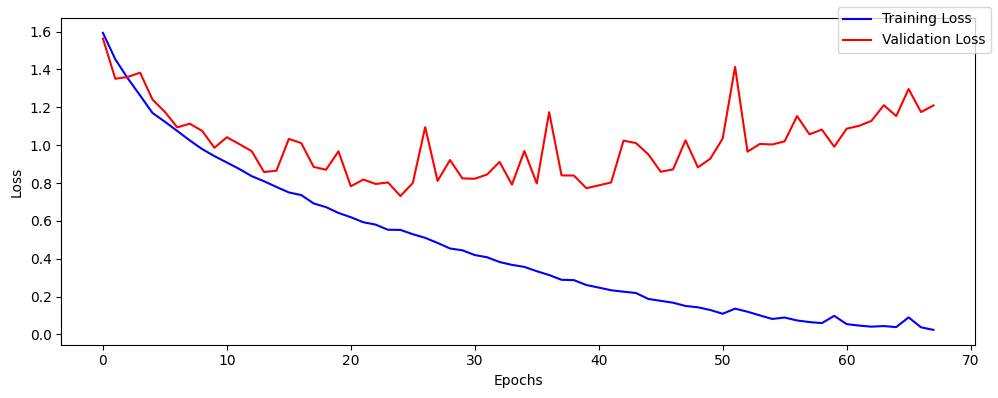

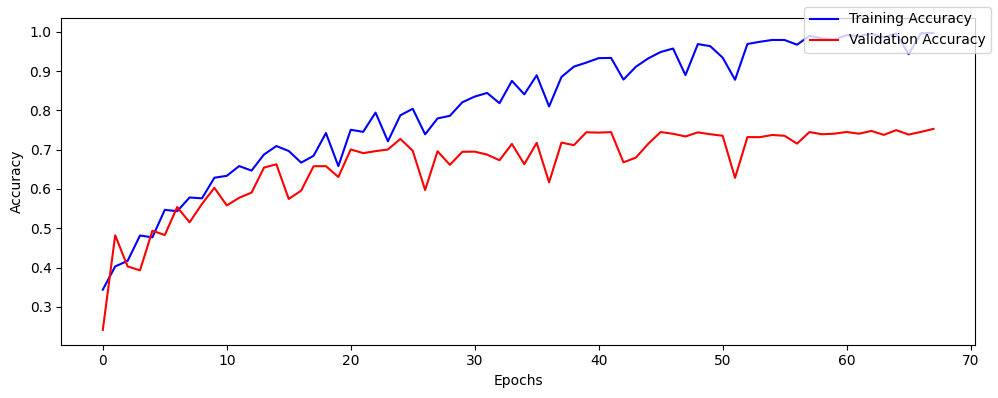

In [73]:
cnn_weight_m2.plot_losses()
cnn_weight_m2.plot_accuracies()

In [74]:
# evaluate on test_loader
test_acc = cnn_weight_m2.calculate_accuracy(test_loader)
print(f"Test Accuracy for weight m2: {test_acc*100:.2f}%")

Test Accuracy for weight m2: 74.94%


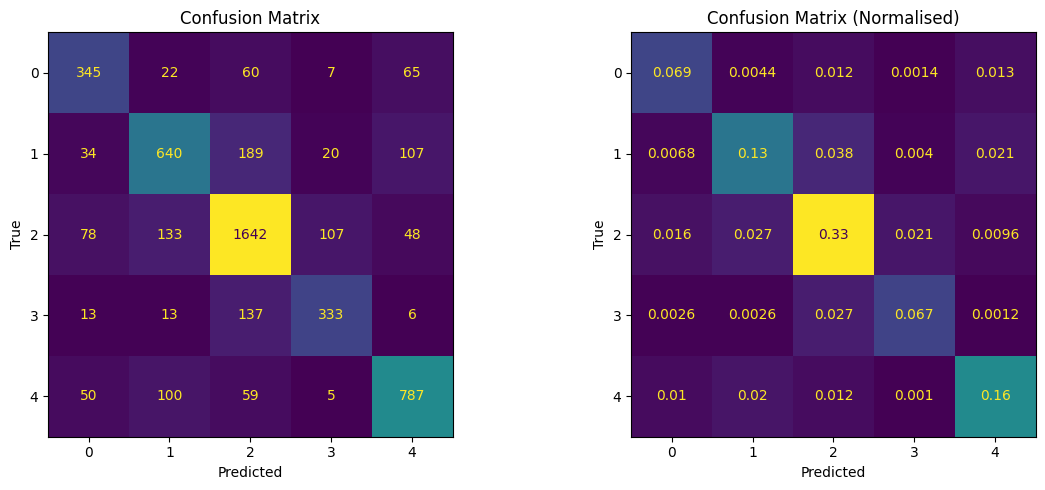

In [92]:
# plot confusion maxtrix  on test loader
test_weight_preds, test_weight_labels = cnn_weight_m2.generate_confusion_matrix(test_loader)
cnn_weight_m2.plot_confusion_matrix(test_weight_labels, test_weight_preds)

applying weightedRandomSampler approach likely improved the model ability to learn from minority classes as the model has improved on class 0 and 3, leading to higher training accuracy. but lacking the ability to generalise to the validation, which may be due to differences in class distribution between the training and validation sets or due to overfitting.

### 3) add dropout layer

In [85]:
# model configuration
# apply convolutional nn 2 blocks
torch.manual_seed(42)
m2 = nn.Sequential()
# featuriser
# block 1
m2.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
m2.add_module('relu1', nn.ReLU()) # activation
m2.add_module('maxp1', nn.MaxPool2d(kernel_size=2, stride =2)) # pooling

# block 2
m2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
m2.add_module('relu2', nn.ReLU())
m2.add_module('maxp2', nn.MaxPool2d(kernel_size=2, stride =2))

# Flattening
m2.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
m2.add_module('fc1', nn.Linear(in_features=8*8*64, out_features=64))
m2.add_module('relu3', nn.ReLU())
m2.add_module('dropout', nn.Dropout(p=0.5)) # add dropout layer
# Output Layer
m2.add_module('fc2', nn.Linear(in_features=64, out_features=5)) # number of new clasess

In [86]:
torch.manual_seed(42)

lr = 0.02
multi_loss_fn_m2 = nn.CrossEntropyLoss()
optimizer_m2 = optim.SGD(m2.parameters(), lr=lr)

n_epochs = 100
cnn_dropout_m2 = ModelBuilder(m2, multi_loss_fn_m2, optimizer_m2, print_loss_freq=5)
cnn_dropout_m2.set_loaders(train_loader, val_loader)
cnn_dropout_m2.train(n_epochs, target_accuracy=0.75)

Epoch 5, Train Loss: 1.2110, Train Acc: 0.5250, Val Loss: 1.1438, Val Acc: 0.5478
Epoch 10, Train Loss: 1.0527, Train Acc: 0.5773, Val Loss: 1.0281, Val Acc: 0.5910
Epoch 15, Train Loss: 0.9417, Train Acc: 0.6088, Val Loss: 0.9455, Val Acc: 0.6212
Epoch 20, Train Loss: 0.8605, Train Acc: 0.6649, Val Loss: 0.8517, Val Acc: 0.6708
Epoch 25, Train Loss: 0.7810, Train Acc: 0.6949, Val Loss: 0.7867, Val Acc: 0.6954
Epoch 30, Train Loss: 0.7233, Train Acc: 0.7379, Val Loss: 0.7257, Val Acc: 0.7228
Epoch 35, Train Loss: 0.6657, Train Acc: 0.7423, Val Loss: 0.7288, Val Acc: 0.7266
Epoch 40, Train Loss: 0.6025, Train Acc: 0.7655, Val Loss: 0.7070, Val Acc: 0.7376
Early stopping at epoch 44 as validation accuracy reached 75.00%


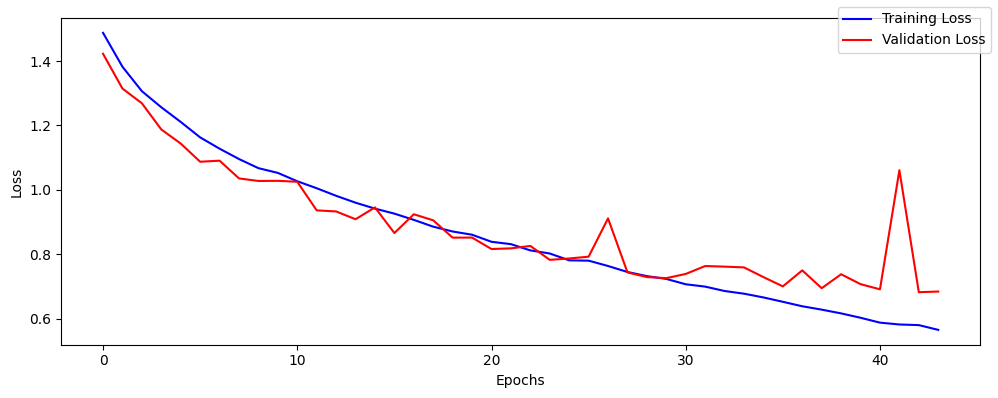

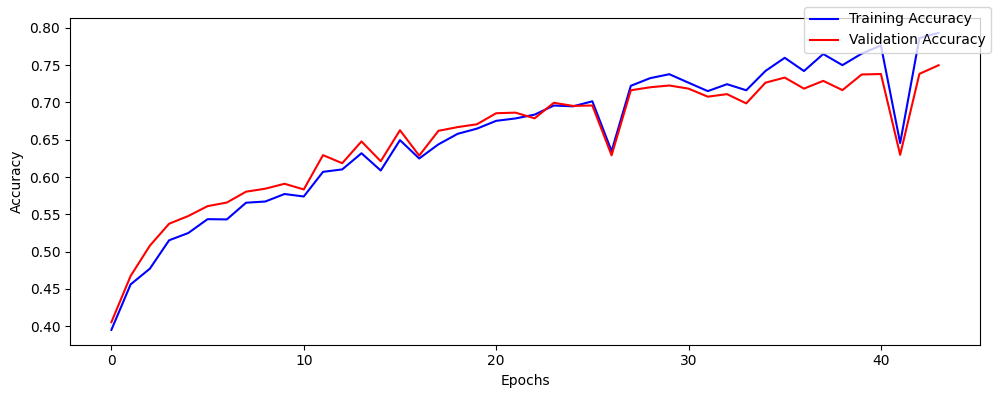

In [87]:
cnn_dropout_m2.plot_losses()
cnn_dropout_m2.plot_accuracies()

In [88]:
# evaluate on test_loader
test_acc = cnn_dropout_m2.calculate_accuracy(test_loader)
print(f"Test Accuracy for dropout m2: {test_acc*100:.2f}%")

Test Accuracy for dropout m2: 74.86%


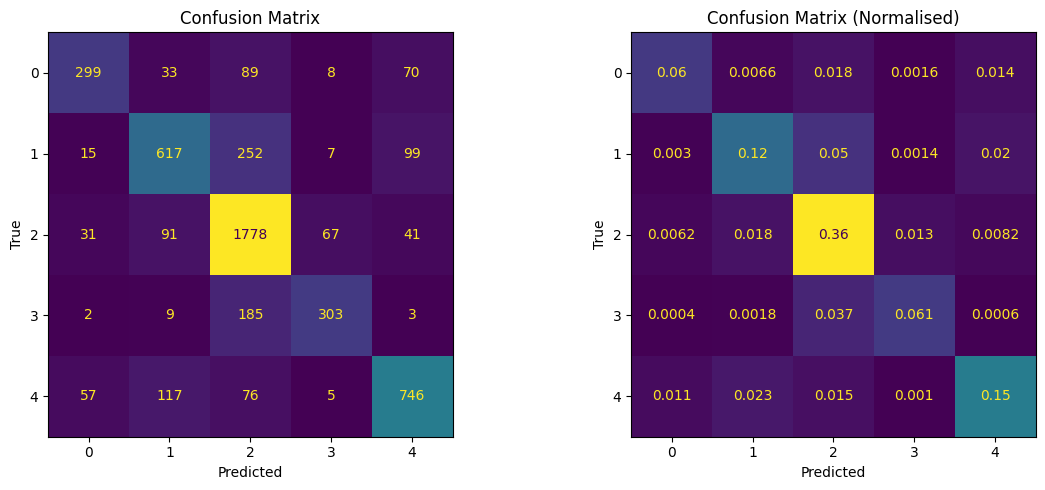

In [93]:
# plot confusion maxtrix  on test loader
test_drop_preds, test_drop_labels = cnn_dropout_m2.generate_confusion_matrix(test_loader)
cnn_dropout_m2.plot_confusion_matrix(test_drop_labels, test_drop_preds)

Test accuray has lower than the other models because of the validation model for applied dropout has stopped early at exactly 75% while others had stopped at higher n_epoch and a bit higher accuracy.
Adding dropout layer approach appears to have reduced overfitting as well as the validation loss and accuracy are much more stable, suggesting improved generalisation. This configuration appears to provide a more robust model than previous versions without dropout.

**Summary**

Adding a dropout layer has proven effective in mitigating overfitting and improving the model's stability, resulting in better generalisation to unseen data. While dropout has shown the most impact on performance, combining it with other approaches such as feature scaling/normalization and class balancing techniques like WeightedRandomSampler can enhance the model's ability to learn effectively and generalise well. By using these techniques together, the model can achieve more robust performance and be better suited for real-world applications where data distributions may vary.